In [32]:
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import glob
site=['RUSH','UCMC']

## Discrimination

In [33]:
roc_files = glob.glob("roc_curve_data_*.csv")
roc_dataframes = [pd.read_csv(file) for file in roc_files]
merged_roc_dataframe = pd.concat(roc_dataframes, ignore_index=True)

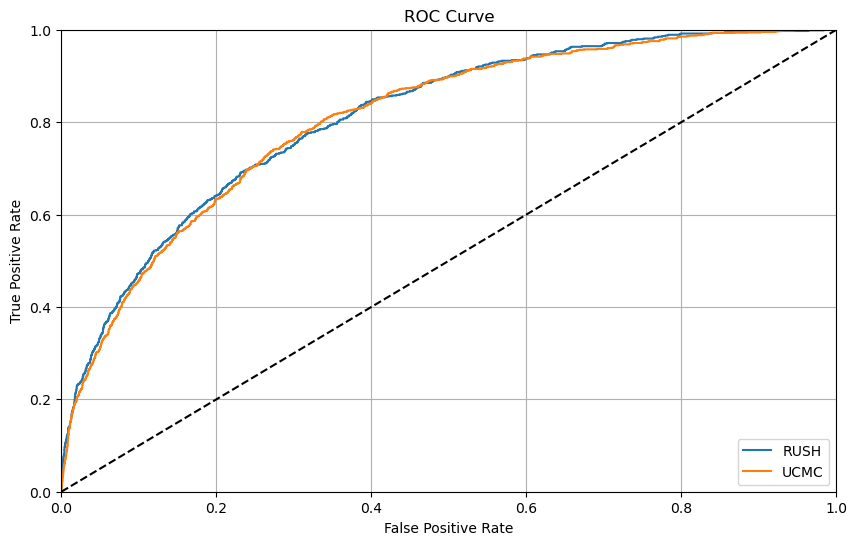

In [34]:

# Plot ROC AUC for each site
plt.figure(figsize=(10, 6))

sites = merged_roc_dataframe['site'].unique()
for site in sites:
    site_data = merged_roc_dataframe[merged_roc_dataframe['site'] == site]
    plt.plot(site_data['fpr'], site_data['tpr'], label=f'{site}')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Calibration 

In [35]:
cal_files = glob.glob("calibration_data_*.csv")
cal_dataframes = [pd.read_csv(file) for file in cal_files]
merged_cal_dataframe = pd.concat(cal_dataframes, ignore_index=True)

In [45]:
merged_cal_dataframe.to_csv('Rush_Uofc_cal_plot_df.csv',index=False)

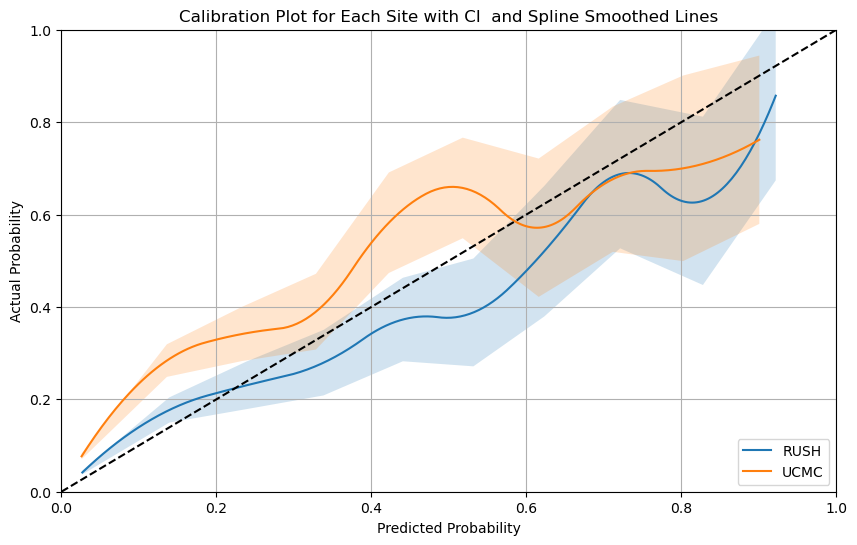

In [36]:
# Plotting with CI shading and smoothed lines with corrected legend
plt.figure(figsize=(10, 6))

sites = merged_cal_dataframe['site'].unique()
for site in sites:
    site_data = merged_cal_dataframe[merged_cal_dataframe['site'] == site]
    # Sort the data by predicted_prob to ensure smooth interpolation
    site_data = site_data.sort_values(by='predicted_prob')
    
    # Smoothing the line with spline interpolation
    x_new = np.linspace(site_data['predicted_prob'].min(), site_data['predicted_prob'].max(), 300)
    spl = make_interp_spline(site_data['predicted_prob'], site_data['actual_prob'], k=2)
    y_smooth = spl(x_new)
    
    plt.plot(x_new, y_smooth, label=f'{site}')
    plt.fill_between(site_data['predicted_prob'], site_data['lower_ci'], site_data['upper_ci'], alpha=0.2)

plt.plot([0, 1], [0, 1], 'k--')  # Perfect calibration line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Predicted Probability')
plt.ylabel('Actual Probability')
plt.title('Calibration Plot for Each Site with CI  and Spline Smoothed Lines')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# Clinical utility 

In [37]:
top_files = glob.glob("Top_N_percentile_PPV_*.csv")
top_dataframes = [pd.read_csv(file) for file in top_files]
merged_top_dataframe = pd.concat(top_dataframes, ignore_index=True)

c:\Users\vchaudha\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\vchaudha\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


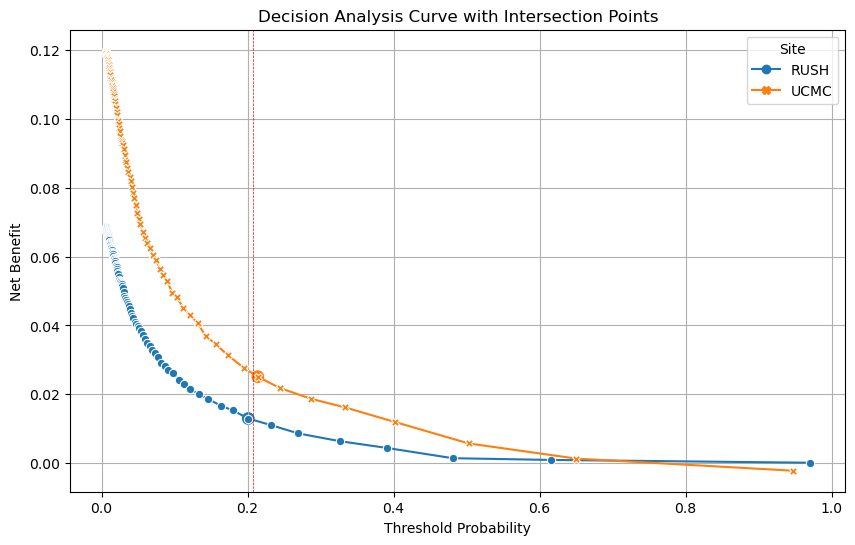

In [38]:
df = merged_top_dataframe

# Calculate n and net_benefit
df['n'] = df['TN'] + df['FP'] + df['FN'] + df['TP']
df['net_benefit'] = (df['TP'] - df['FP'] * (df['Thr Value'] / (1 - df['Thr Value']))) / df['n']

# Find intersection points
threshold_value = 0.208  # Example threshold value
intersection_points = df.loc[(df.groupby('site_name')['Thr Value'].apply(lambda x: (x - threshold_value).abs().idxmin()))]

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Thr Value', y='net_benefit', hue='site_name', style='site_name', markers=True, dashes=False)
plt.axvline(x=threshold_value, color='red', linestyle='--', linewidth=0.5)
sns.scatterplot(data=intersection_points, x='Thr Value', y='net_benefit', hue='site_name', s=100, legend=False)

plt.xlabel('Threshold Probability')
plt.ylabel('Net Benefit')
plt.title('Decision Analysis Curve with Intersection Points')
plt.legend(title='Site')
plt.grid(True)
plt.show()

### metric

In [41]:
met_files = glob.glob("result_metrics_2_*.csv")
met_dataframes = [pd.read_csv(file) for file in met_files]
merged_met_dataframe = pd.concat(met_dataframes, ignore_index=True)

# plot on one

c:\Users\vchaudha\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\vchaudha\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


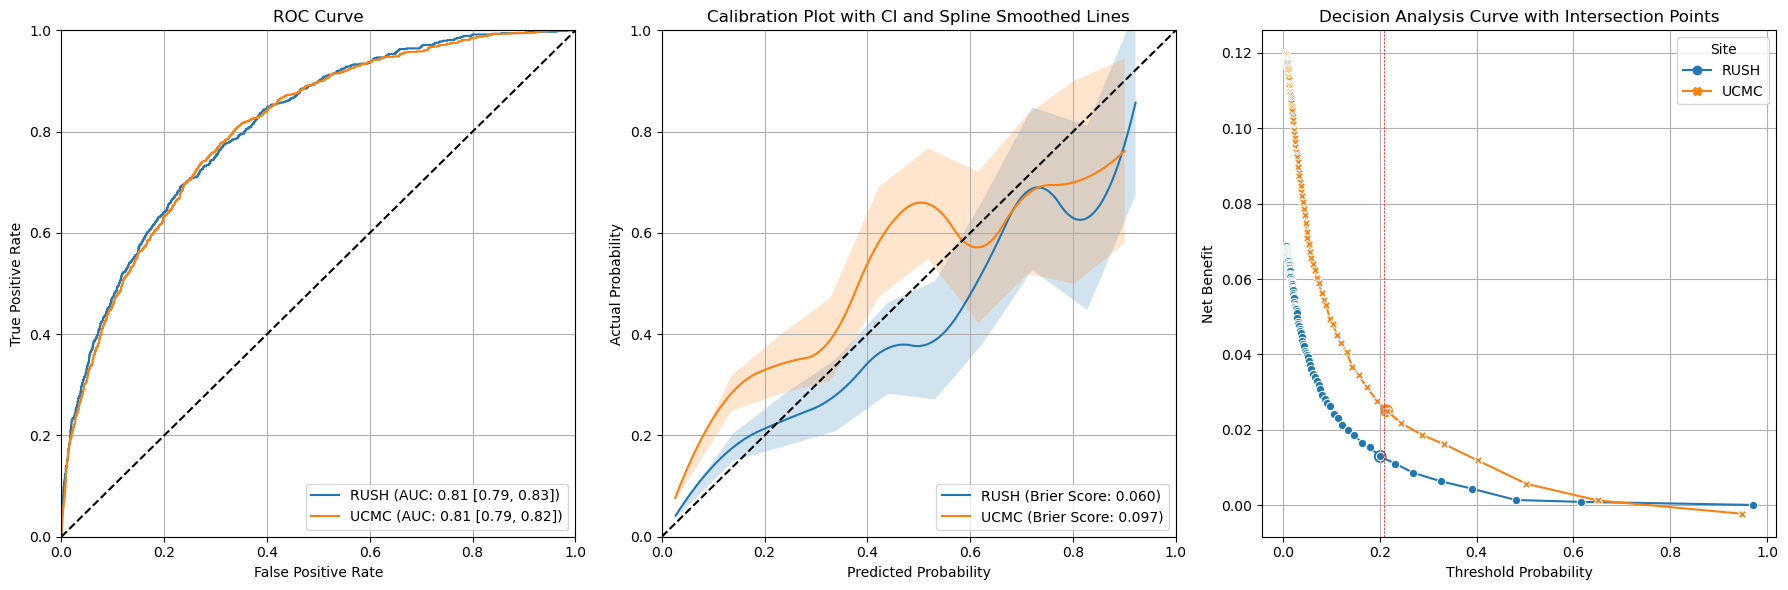

In [43]:

# Calculate 'n' and 'net_benefit'
df = merged_top_dataframe
df['n'] = df['TN'] + df['FP'] + df['FN'] + df['TP']
df['net_benefit'] = (df['TP'] - df['FP'] * (df['Thr Value'] / (1 - df['Thr Value']))) / df['n']

# Find intersection points
threshold_value = 0.208  # Example threshold value
intersection_points = df.loc[(df.groupby('site_name')['Thr Value'].apply(lambda x: (x - threshold_value).abs().idxmin()))]

# Extract AUC and Brier Score values from merged_met_dataframe
auc_values = merged_met_dataframe[merged_met_dataframe['Metric'] == 'ROC AUC'].set_index('SiteName')['Value'].to_dict()
auc_ci_lower = merged_met_dataframe[merged_met_dataframe['Metric'] == 'ROC AUC'].set_index('SiteName')['CI Lower'].to_dict()
auc_ci_upper = merged_met_dataframe[merged_met_dataframe['Metric'] == 'ROC AUC'].set_index('SiteName')['CI Upper'].to_dict()
brier_scores = merged_met_dataframe[merged_met_dataframe['Metric'] == 'Brier Score Loss'].set_index('SiteName')['Value'].to_dict()

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# ROC Plot
axs[0].set_title('ROC Curve')
for site in merged_roc_dataframe['site'].unique():
    site_data = merged_roc_dataframe[merged_roc_dataframe['site'] == site]
    auc = auc_values[site]
    ci_lower = auc_ci_lower[site]
    ci_upper = auc_ci_upper[site]
    label = f'{site} (AUC: {auc:.2f} [{ci_lower:.2f}, {ci_upper:.2f}])'
    axs[0].plot(site_data['fpr'], site_data['tpr'], label=label)
axs[0].plot([0, 1], [0, 1], 'k--')
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.0])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].legend(loc='lower right')
axs[0].grid(True)

# Calibration Plot
axs[1].set_title('Calibration Plot with CI and Spline Smoothed Lines')
for site in merged_cal_dataframe['site'].unique():
    site_data = merged_cal_dataframe[merged_cal_dataframe['site'] == site]
    site_data = site_data.sort_values(by='predicted_prob')
    x_new = np.linspace(site_data['predicted_prob'].min(), site_data['predicted_prob'].max(), 300)
    spl = make_interp_spline(site_data['predicted_prob'], site_data['actual_prob'], k=2)
    y_smooth = spl(x_new)
    brier_score = brier_scores[site]
    label = f'{site} (Brier Score: {brier_score:.3f})'
    axs[1].plot(x_new, y_smooth, label=label)
    axs[1].fill_between(site_data['predicted_prob'], site_data['lower_ci'], site_data['upper_ci'], alpha=0.2)
axs[1].plot([0, 1], [0, 1], 'k--')
axs[1].set_xlim([0.0, 1.0])
axs[1].set_ylim([0.0, 1.0])
axs[1].set_xlabel('Predicted Probability')
axs[1].set_ylabel('Actual Probability')
axs[1].legend(loc='lower right')
axs[1].grid(True)

# Clinical Utility Plot
axs[2].set_title('Decision Analysis Curve with Intersection Points')
sns.lineplot(ax=axs[2], data=df, x='Thr Value', y='net_benefit', hue='site_name', style='site_name', markers=True, dashes=False)
axs[2].axvline(x=threshold_value, color='red', linestyle='--', linewidth=0.5)
sns.scatterplot(ax=axs[2], data=intersection_points, x='Thr Value', y='net_benefit', hue='site_name', s=100, legend=False)
axs[2].set_xlabel('Threshold Probability')
axs[2].set_ylabel('Net Benefit')
axs[2].legend(title='Site')
axs[2].grid(True)

plt.tight_layout()
plt.show()